In [15]:
import os

from bigdl.nn.criterion import *
from bigdl.nn.layer import *
from bigdl.optim.optimizer import Adam
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DoubleType, StringType

from zoo.common.nncontext import *
from zoo.feature.image import *
from zoo.pipeline.nnframes import *

import matplotlib.pyplot as plt
from PIL import Image

In [2]:
sc = init_nncontext("TransferLearningUsingBigDL")

### Define paths to our model and train and validation sets

In [3]:
model_path = '<YOUR-ABSOLUTE-PATH>/analytics-zoo_resnet-50_imagenet_0.1.0.model'
train_path = '<YOUR-ABSOLUTE-PATH>/data/train/*'
val_path = '<YOUR-ABSOLUTE-PATH>/data/val/*'
test_path = '<YOUR-ABSOLUTE-PATH>/data/test/*'

### Construct a training dataframe with assigned lables for training

In [4]:
getFileName = udf(lambda row: os.path.basename(row[0]), StringType())
getLabel = udf(lambda row: 1.0 if 'ants' in row[0] else 2.0, DoubleType())

trainingDF = NNImageReader.readImages(train_path, sc, resizeH=300, resizeW=300, image_codec=1)
trainingDF = trainingDF.withColumn('filename', getFileName('image')).withColumn('label', getLabel('image'))

### Construct a validation dataframe from the validation dataset

In [5]:
validationDF = NNImageReader.readImages(val_path, sc, resizeH=300, resizeW=300, image_codec=1)
validationDF = validationDF.withColumn('filename', getFileName('image')).withColumn('label', getLabel('image'))

### Create all the transformations on images

In [6]:
transformer = ChainedPreprocessing(
    [RowToImageFeature(), ImageResize(256, 256), ImageCenterCrop(224, 224),
     ImageChannelNormalize(123.0, 117.0, 104.0), ImageMatToTensor(), ImageFeatureToTensor()])

creating: createRowToImageFeature
creating: createImageResize
creating: createImageCenterCrop
creating: createImageChannelNormalize
creating: createImageMatToTensor
creating: createImageFeatureToTensor
creating: createChainedPreprocessing


### Load pre-trained ResNet-50

In [7]:
preTrainedNNModel = NNModel(Model.loadModel(model_path), transformer) \
    .setFeaturesCol("image") \
    .setPredictionCol("embedding")

creating: createTensorToSample
creating: createChainedPreprocessing
creating: createNNModel


### Layers in ResNet-50

In [8]:
for layer in preTrainedNNModel.model.layers:
    print(layer.name())

data
conv1
bn_conv1
scale_conv1
conv1_relu
pool1
res2a_branch2a
bn2a_branch2a
scale2a_branch2a
res2a_branch2a_relu
res2a_branch2b
bn2a_branch2b
scale2a_branch2b
res2a_branch2b_relu
res2a_branch1
res2a_branch2c
bn2a_branch1
bn2a_branch2c
scale2a_branch2c
scale2a_branch1
res2a
res2a_relu
res2b_branch2a
bn2b_branch2a
scale2b_branch2a
res2b_branch2a_relu
res2b_branch2b
bn2b_branch2b
scale2b_branch2b
res2b_branch2b_relu
res2b_branch2c
bn2b_branch2c
scale2b_branch2c
res2b
res2b_relu
res2c_branch2a
bn2c_branch2a
scale2c_branch2a
res2c_branch2a_relu
res2c_branch2b
bn2c_branch2b
scale2c_branch2b
res2c_branch2b_relu
res2c_branch2c
bn2c_branch2c
scale2c_branch2c
res2c
res2c_relu
res3a_branch2a
bn3a_branch2a
scale3a_branch2a
res3a_branch2a_relu
res3a_branch2b
bn3a_branch2b
scale3a_branch2b
res3a_branch2b_relu
res3a_branch1
res3a_branch2c
bn3a_branch1
bn3a_branch2c
scale3a_branch2c
scale3a_branch1
res3a
res3a_relu
res3b_branch2a
bn3b_branch2a
scale3b_branch2a
res3b_branch2a_relu
res3b_branch2b
bn3b

### Create the last layer of ResNet-50 that needs to be changed

In [9]:
lrModel = Sequential().add(Linear(1000, 2)).add(LogSoftMax())
classifier = NNClassifier(lrModel, ClassNLLCriterion(), SeqToTensor([1000])) \
    .setOptimMethod(SGD(learningrate=0.001, momentum=0.9)) \
    .setBatchSize(4) \
    .setMaxEpoch(25) \
    .setFeaturesCol("embedding") \
    .setCachingSample(False)

creating: createSequential
creating: createLinear
creating: createLogSoftMax
creating: createClassNLLCriterion
creating: createSeqToTensor
creating: createScalarToTensor
creating: createFeatureLabelPreprocessing
creating: createNNClassifier
creating: createDefault
creating: createSGD


### Create the pipeline with the last layer as our new classifier layer that detects just 2 classes

In [10]:
pipeline = Pipeline(stages=[preTrainedNNModel, classifier])

### Fit the model on training dataset and use validation dataset to get pridictions

In [11]:
antbeeModel = pipeline.fit(trainingDF)
predictionDF = antbeeModel.transform(validationDF).cache()
# predictionDF.sample(False, 0.1).show()

creating: createToTuple
creating: createChainedPreprocessing


### Find accuracy of our classifications

In [12]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictionDF)
# expected error should be less than 10%
print("Test Error = %g " % (1.0 - accuracy))

Test Error = 0.408163 


### Do inference on test images and show predicted image

In [13]:
# Test dataframe
testDF = NNImageReader.readImages(test_path, sc, resizeH=300, resizeW=300, image_codec=1)
testDF = testDF.withColumn('filename', getFileName('image')).withColumn('label', getLabel('image'))
testPredDF = antbeeModel.transform(testDF).cache()
row = testPredDF.first().asDict()

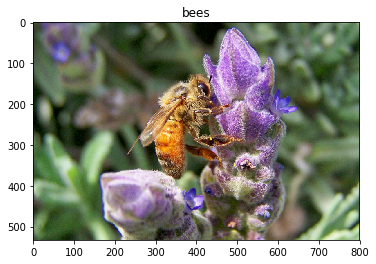

In [14]:
# Show image function
def showImage(row):
    plt.imshow(Image.open(row['image'][0][5:]))
    title = 'ants' if row['prediction'] == 1.0 else 'bees'
    plt.title(title)
    
showImage(row)